<a href="https://colab.research.google.com/github/michelgawron/NLP_LSTM/blob/master/lstm_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from random import choices, choice
import numpy as np
import spacy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.manual_seed(1)

# Dataset class

We are going to create a Dataset class to handle our dataset

In [0]:
class Dataset():
  def __init__(self, dataset):
    """
    Initialize a dataset object
    """
    self.__dataset = dataset
    self.__nlp = spacy.load("en_core_web_sm")
    
  def set_dataset(self, dataset):
    self.__dataset = dataset
    
    
  def preprocess_data(self, min_word_appearance=1):
    """
    Preprocess the data in the dataset
    Args:
      - min_word_appearance: Minimum number of occurences of a word to be used in the corpus
    """
    # Tokenizing the words
    print("Started pre-processing data..")
    list_docs = []
    for doc in self.__nlp.tokenizer.pipe(self.__dataset["title"], batch_size=10000):
      list_docs.append(doc)
    self.__dataset["spacy"] = list_docs
    print("Tokenizer done !")
    
    # Getting one hot vectors for categories
    dict_classes = {"b": 0, "m": 1, "e": 2, "t": 3}
    self.__dataset["ncat"] = self.__dataset["cat"].apply(lambda x: [1 if cat == x else 0 for cat in dict_classes.keys()])
    print("Categories done !")
    
    # Applying maj and up tags
    self.__dataset["tagged"] = self.__dataset["spacy"].apply(lambda x: self.apply_tags(x))
    print("Sentences tagged !")
    
    # Getting word count
    self.__dataset["word_count"] = self.__dataset["tagged"].apply(lambda x: {word: x.count(word) for word in set(x)})
    
    # Creating a dictionary containing the whole corpus word count, a second dict contains elements that appears too rarely to be used
    self.__word_count = self.create_word_count(self.__dataset["word_count"])
    self.__unk_words = {k: w for k, w in self.__word_count.items() if w == min_word_appearance}
    print("Words counted !")
    
    # Tagging unknown words
    self.__dataset["tagged_unk"] = self.__dataset["tagged"].apply(lambda x: [w if self.__unk_words.get(w, 0) == 0 else "xxunk" for w in x])
    print("Unknown words tagged !")
    
    # Creating a dictionary of integer embeddings
    self.__int_embed = self.create_integer_embedding(self.__dataset["tagged_unk"])
    print("Integers embeddings dict created !")
    
    # Creating a vector of integers embeddings for the sentences
    self.__dataset["int_tagged"] = self.__dataset["tagged_unk"].apply(lambda x: [self.__int_embed.get(w) for w in x])
    print("Sentences embedded into integers")
    
    self.__dataset = self.__dataset.drop(["tagged", "word_count", "spacy", "cat"], axis=1)
    print("Dropped what should be dropped")
    
  def create_train_test_tensors(self, train_size=0.90):
    """
    Creates four tensors representing the train and test data
    """
    train_limit = train_size * len(self.__dataset)
    self.__train_dataset, self.__test_dataset = train_test_split(self.__dataset[(self.__dataset["tagged_unk"].apply(lambda x: len(x)) > 5) & (self.__dataset["tagged_unk"].apply(lambda x: len(x)) <= 50)], train_size=train_size)
    #self.__dataset = self.__dataset[self.__dataset["tagged_unk"].apply(lambda x: len(x)) > 5]
    self.__train_datasets = [self.__train_dataset[(self.__train_dataset["tagged_unk"].apply(lambda x: len(x)) > 5*i) & (self.__train_dataset["tagged_unk"].apply(lambda x: len(x)) <= 5*(i+1))] for i in range(2, 7)]
    self.__test_datasets = [self.__test_dataset[(self.__test_dataset["tagged_unk"].apply(lambda x: len(x)) > 5*i) & (self.__test_dataset["tagged_unk"].apply(lambda x: len(x)) <= 5*(i+1))] for i in range(2, 7)]
    # We need to transform it to tensor and store it
    # Then we need to create two functions getBatch, and padSequence to getbatches of same sequence lengths
    
  def pad_sentences(self, batch):
    """
    Pad sentences from a batch with zeroes
    """
    length = max([len(seq) for seq in batch])
    return torch.tensor([seq + [0] * (length - len(seq)) for seq in batch]).view(len(batch), length, 1)
  
  def get_batch(self, size=32, test=False):
    """
    Get a batch for training or testing
    """
    if test:
      dataset = [self.__test_datasets[1]]
      #dataset = choices(self.__test_datasets, weights=[len(ds)for ds in self.__test_datasets], k=1) # Doesn't preserve the initial type - need to change it
    else:
      dataset = choices(self.__train_datasets, weights=[len(ds) for ds in self.__train_datasets], k=1)
    # choices returns a list of 
    dataset = dataset[0]
    batch = dataset.sample(n=size)
    x_data = batch["int_tagged"]
    y_data = list(batch["ncat"])
    return self.pad_sentences(x_data).to(device), torch.tensor(y_data).view(size, 4).to(device) #separate x and y
  
  def apply_tags(self, sentence):
    """
    Function used to apply a set of tags to our words
    Tags:
      - xxmaj: words starting with uppercase
      - xxup: full uppercase words
    """
    res = []
    for t in sentence:
      if t.text[0].isupper() and t.text[1:].islower():
        res.append("xxmaj")
      elif t.text[:].isupper():
        res.append("xxup")
      res.append(t.text.lower())
    return res
  
  def create_word_count(self, list_wc):
    """
    Create a dictionary containing word counts
    Args:
      - list_wc: An iterable containing dictionaries of word_counts
    """
    res = {}
    for index, el in list_wc.iteritems():
      # Iterating over the dict of words for each tagged sentence, and appending values to result dict
      for word, counter in el.items():
        res[word] = res.get(word, 0) + counter
    return res
  
  def create_integer_embedding(self, tagged_s):
    """
    Create an integer embedding for our sentences
    """
    res = {}
    ind = 1
    for index, el in tagged_s.iteritems():
      # Iterating over the list of tagged sentences, containing words
      for word in el:
        if word not in res:
          res[word] = ind
          ind += 1
    return res
  
  def get_vocab_size(self):
    return len(self.__int_embed) + 1
  
  def head(self, *args, **kwargs):
    return self.__dataset.head(*args, **kwargs)

In [0]:
class myModel(nn.Module):
  """
  Definition of our model
  """
  
  def __init__(self, input_dim, hidden_dim, vocab_size, output_dim=4, num_layers=1):
    """
      Defining a LSTM model - parameters speaks for themselves
    """
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.embeddings = nn.Embedding(vocab_size, input_dim)
    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, dropout=0.2)
    
    self.linear = nn.Linear(self.hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)
    
  def init_hidden(self, size):
    """
        We need to create two empty vectors to store hn and cn at initial state
    """
    return (torch.zeros(self.num_layers, size, self.hidden_dim).to(device),
           torch.zeros(self.num_layers, size, self.hidden_dim).to(device))
  
  def forward(self, inputs):
    """
      Computes a single forward pass on our input batch
    """
    #print(input.shape)
    #print(len(input))
    # Get sizes
    batch_size = inputs.size(0)
    seq_size = inputs.size(1)
    
    # Embedding layer, getting 10 dimension vectors
    embeds = self.embeddings(inputs).view(inputs.size(0), inputs.size(1), self.input_dim)
    
    # Creating h0, c0
    h0, c0 = self.init_hidden(embeds.size(0))
    
    # Computing lstm out and transforming the output @read(contiguous space)
    out, (h0, c0) = self.lstm(embeds, (h0, c0))
    lstm_out = out.contiguous().view(batch_size, seq_size, self.hidden_dim)
    
    # Applying linear layer and softmax for output
    output = self.linear(lstm_out[:, -1, :])
    
    # Getting last layer of probabilities
    #sig_out = self.softmax(output).view(batch_size, seq_size, -1)[:, -1]
    #return sig_out.view(batch_size, self.output_dim)
    return output

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
!ls

--2019-06-26 08:08:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  13.0MB/s    in 2.1s    

2019-06-26 08:08:24 (13.0 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   
2pageSessions.csv  NewsAggregatorDataset.zip  readme.txt
__MACOSX	   newsCorpora.csv	      sample_data


In [0]:
!head newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

# Data import

In [0]:
import pandas as pd

my_df = Dataset(pd.read_csv("./newsCorpora.csv", encoding="latin-1", low_memory=False, sep="\t", header=None, 
                    names=[0, "title", "url", "newspaper", "cat", "cluster", "website", "timestamp"]).drop([0, "url", "newspaper", "cluster", "website", "timestamp"], axis=1))
my_df.head(5)

,title,cat
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [0]:
my_df.preprocess_data()
my_df.head(10)

Started pre-processing data..
Tokenizer done !
Categories done !
Sentences tagged !
Words counted !
Unknown words tagged !
Integers embeddings dict created !
Sentences embedded into integers
Dropped what should be dropped


,title,ncat,tagged_unk,int_tagged
0,"Fed official says weak data caused by weather,...","[1, 0, 0, 0]","[xxmaj, fed, official, says, weak, data, cause...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1,Fed's Charles Plosser sees high bar for change...,"[1, 0, 0, 0]","[xxmaj, fed, 's, xxmaj, charles, xxmaj, plosse...","[1, 2, 15, 1, 16, 1, 17, 18, 19, 20, 21, 22, 2..."
2,US open: Stocks fall after Fed official hints ...,"[1, 0, 0, 0]","[xxup, us, open, :, xxmaj, stocks, fall, after...","[27, 28, 29, 30, 1, 31, 32, 33, 1, 2, 3, 34, 3..."
3,"Fed risks falling 'behind the curve', Charles ...","[1, 0, 0, 0]","[xxmaj, fed, risks, falling, ', behind, the, c...","[1, 2, 37, 38, 39, 40, 41, 42, 39, 10, 1, 16, ..."
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,"[1, 0, 0, 0]","[xxmaj, fed, 's, xxmaj, plosser, :, xxmaj, nas...","[1, 2, 15, 1, 17, 30, 1, 43, 1, 9, 1, 44, 1, 4..."
5,Plosser: Fed May Have to Accelerate Tapering Pace,"[1, 0, 0, 0]","[xxmaj, plosser, :, xxmaj, fed, xxmaj, may, xx...","[1, 17, 30, 1, 2, 1, 48, 1, 49, 50, 1, 51, 1, ..."
6,Fed's Plosser: Taper pace may be too slow,"[1, 0, 0, 0]","[xxmaj, fed, 's, xxmaj, plosser, :, xxmaj, tap...","[1, 2, 15, 1, 17, 30, 1, 14, 24, 48, 52, 53, 13]"
7,Fed's Plosser expects US unemployment to fall ...,"[1, 0, 0, 0]","[xxmaj, fed, 's, xxmaj, plosser, expects, xxup...","[1, 2, 15, 1, 17, 54, 27, 28, 55, 50, 32, 50, ..."
8,US jobs growth last month hit by weather:Fed P...,"[1, 0, 0, 0]","[xxup, us, jobs, growth, last, month, hit, by,...","[27, 28, 60, 47, 61, 62, 63, 8, 9, 30, 1, 2, 1..."
9,ECB unlikely to end sterilisation of SMP purch...,"[1, 0, 0, 0]","[xxup, ecb, unlikely, to, end, xxunk, of, xxup...","[27, 65, 66, 50, 58, 67, 25, 27, 68, 69, 70, 71]"


In [0]:
df_copy = my_df._Dataset__dataset
vocab_size = my_df.get_vocab_size()

In [0]:
my_df = Dataset(df_copy)
my_df.head(5)

,title,ncat,tagged_unk,int_tagged
0,"Fed official says weak data caused by weather,...","[1, 0, 0, 0]","[xxmaj, fed, official, says, weak, data, cause...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1,Fed's Charles Plosser sees high bar for change...,"[1, 0, 0, 0]","[xxmaj, fed, 's, xxmaj, charles, xxmaj, plosse...","[1, 2, 15, 1, 16, 1, 17, 18, 19, 20, 21, 22, 2..."
2,US open: Stocks fall after Fed official hints ...,"[1, 0, 0, 0]","[xxup, us, open, :, xxmaj, stocks, fall, after...","[27, 28, 29, 30, 1, 31, 32, 33, 1, 2, 3, 34, 3..."
3,"Fed risks falling 'behind the curve', Charles ...","[1, 0, 0, 0]","[xxmaj, fed, risks, falling, ', behind, the, c...","[1, 2, 37, 38, 39, 40, 41, 42, 39, 10, 1, 16, ..."
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,"[1, 0, 0, 0]","[xxmaj, fed, 's, xxmaj, plosser, :, xxmaj, nas...","[1, 2, 15, 1, 17, 30, 1, 43, 1, 9, 1, 44, 1, 4..."


In [0]:
my_df.create_train_test_tensors()
print([len(i) for i in my_df._Dataset__train_datasets])
print([len(i) for i in my_df._Dataset__test_datasets])

[124858, 96145, 55584, 23293, 3903]
[13750, 10657, 6175, 2683, 423]


In [0]:
batch_x, batch_y = my_df.get_batch(size=32)

In [0]:
model = myModel(300, 300, vocab_size, num_layers=2).to(device)
print(model)

myModel(
  (embeddings): Embedding(38186, 300)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=300, out_features=4, bias=True)
  (softmax): Softmax()
)


In [0]:
sum([1 if a == b else 0 for (a, b) in list(zip(np.argmax(model(batch_x).detach().numpy(), axis=1), np.argmax(batch_y.numpy(), axis=1)))])

In [0]:
batch_size = [128, 256, 512]
lrs = [0.01, 0.001, 0.0001]

In [0]:
test_BCE_loss = []
test_CE_loss = []
test_acc = []
train_acc = []


for sz, lr in zip(batch_size, lrs):
  #loss_fn = torch.nn.BCELoss(reduction="sum")
  loss_fn = torch.nn.CrossEntropyLoss()
  optim = torch.optim.Adam(model.parameters(), lr=lr)
  
  for t in range(3000):
    # Getting batch of data
    batch_x, batch_y = my_df.get_batch(size=sz)
    
    # Computing loss and predictions
    y_pred = model(batch_x)
    #loss_bce = loss_fn(y_pred.float(), batch_y.float())
    loss = loss_fn(y_pred.float(), torch.argmax(batch_y.float(), 1))
    
    # Gradient and optimizer steps
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # Computing accuracy every 500 steps and generating graphs
    if (t) % 10 == 0:
      # test_size and subset size for loss computing and plotting purpose
      test_size=15000
      subset_size=10000
      
      with torch.no_grad():
        # Creating two loss functions
        #loss_test = torch.nn.BCELoss()
        loss_test_cross_e = torch.nn.CrossEntropyLoss()
        test_batch_x, test_batch_y = my_df.get_batch(size=subset_size, test=True)

        # Generating predictions
        outputs = model(test_batch_x)
        #print(outputs)
        
        # Losses
        #BCE = loss_test(outputs.float(), test_batch_y.float())
        CE = loss_test_cross_e(outputs.float(), torch.argmax(test_batch_y.float(), 1))
        #test_BCE_loss.append(BCE)
        test_CE_loss.append(CE)
        
        # Computing test accuracy
        acc = sum([1 if a == b else 0 for (a, b) in list(zip(np.argmax(outputs.detach().cpu().numpy(), axis=1), np.argmax(test_batch_y.cpu().numpy(), axis=1)))])/subset_size
        test_acc.append(acc)
        
        # Getting train dataset for accuracy computing and computing it
        subset_train = 3000
        train_batch_x, train_batch_y = my_df.get_batch(size=subset_train)
        outputs_train = model(train_batch_x)
        acc_tr = sum([1 if a == b else 0 for (a, b) in list(zip(np.argmax(outputs_train.detach().cpu().numpy(), axis=1), np.argmax(train_batch_y.cpu().numpy(), axis=1)))])/subset_train
        train_acc.append(acc_tr)
        
        if (t) % 500 == 0:
          #print(f"Batch size: {my_size}")
          print(f"Training loss (CE): {loss}")
          #print(f"Test BCELoss = {BCE}")
          print(f"Test CELoss = {CE}")
          print(f"Test accuracy = {acc}")
          print(f"Train accuracy = {acc_tr}")
          print("----------")

Training loss (CE): 1.3855879306793213
Test CELoss = 1.6745727062225342
Test accuracy = 0.2674
Train accuracy = 0.31
----------
Training loss (CE): 0.34555280208587646
Test CELoss = 0.2491496354341507
Test accuracy = 0.913
Train accuracy = 0.902
----------
Training loss (CE): 0.10764802992343903
Test CELoss = 0.2171562761068344
Test accuracy = 0.9247
Train accuracy = 0.9176666666666666
----------
Training loss (CE): 0.06007417291402817
Test CELoss = 0.2013523280620575
Test accuracy = 0.9299
Train accuracy = 0.9356666666666666
----------
Training loss (CE): 0.10680224746465683
Test CELoss = 0.19514340162277222
Test accuracy = 0.9342
Train accuracy = 0.941
----------
Training loss (CE): 0.15155038237571716
Test CELoss = 0.1848246455192566
Test accuracy = 0.9373
Train accuracy = 0.944
----------
Training loss (CE): 0.19512447714805603
Test CELoss = 0.1829252392053604
Test accuracy = 0.9336
Train accuracy = 0.9476666666666667
----------
Training loss (CE): 0.12284480780363083
Test CELoss =

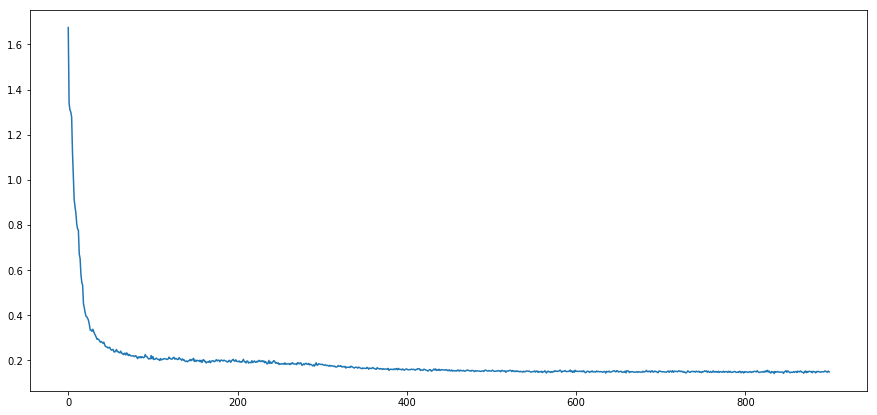

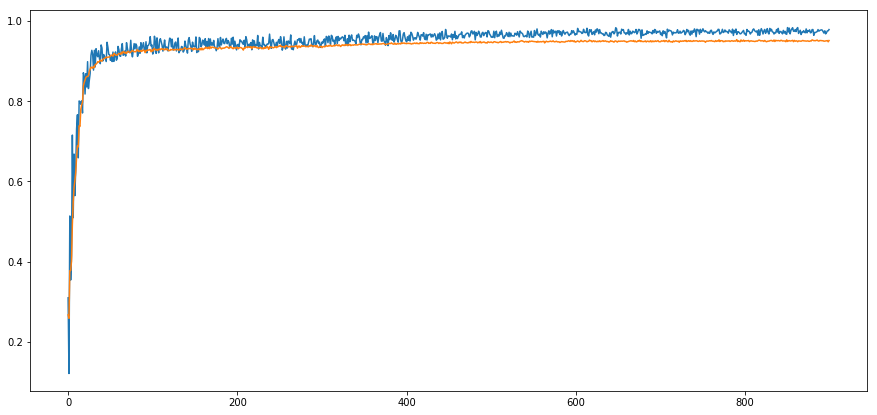

In [0]:
plt.figure(figsize=(15, 7))
#plt.plot(test_BCE_loss)
plt.plot(test_CE_loss)
plt.show()
plt.figure(figsize=(15, 7))
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

In [0]:
my_df.create_train_test_tensors()
len(my_df._Dataset__dataset)

54066

In [0]:
plt.figure(figsize=(15, 7))
my_df._Dataset__dataset["int_tagged"].apply(lambda x: len(x)).value_counts().sort_index().plot.bar()
plt.show()
my_df._Dataset__dataset["int_tagged"].apply(lambda x: len(x)).value_counts().sort_index()

In [0]:
plt.figure(figsize=(15, 7))
my_df._Dataset__dataset["int_tagged"].apply(lambda x: len(x)).value_counts().sort_index().cumsum().plot.bar()
plt.show()

In [0]:
my_df._Dataset__dataset[["int_tagged", "ncat"]][0:10]

In [0]:
# Experiments
"""
1/ Apply tokenization and lemmatization on titles
2/ Transform them on integers
3/ Train a model language to create a vector representation
4/ Use the language model as embedding layer
5/ Train a neural network to predict classes


We can first start by training the neural network without creating language models
Will certainly be longer and yield lower results
"""